In [69]:
import arviz as az
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
plt.style.use('ggplot')
import os
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')

In [70]:
df = pd.read_csv('../formatted_data/transformed_data.csv')
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts = list(grouped_df.apply(lambda x: np.array(x[['intercept', 'component_1', 'component_2']])))
y_depts = list(grouped_df.apply(lambda x: np.array(x[['avg_change_baseline_incidents']]).flatten()))

$$
  y_i = N(X_i \beta_i , \sigma_i^2I)
$$



$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [79]:
dept_names = df.department_name.unique()
dept_idxs, depts = pd.factorize(df.department_name)
coords = {
    "dept": depts,
    "obs_id": np.arange(len(dept_idxs)),
}

with pm.Model(coords=coords) as hierarchical_model:
    dept_idx = pm.Data('dept_indx', dept_idxs, dims="obs_id")

    mus_betas = pm.Normal("mus_beta", mu=0.0, sigma=1e9, shape=3)
    sigmas_sq_betas = pm.InverseGamma('sigmas_squared_betas',alpha=0.5, beta=0.5, shape=3)
    
    betas_offset =  pm.Normal("betas_offset", mu=0, sigma=1, shape=(len(dept_names), 3))
    betas = pm.Deterministic('betas', mus_betas + betas_offset*np.sqrt(sigmas_sq_betas))
    eps = pm.Uniform("eps", lower=0.0, upper=10000, dims='dept')

    mean =  (df[['intercept','component_1','component_2']].to_numpy() * betas[dept_idxs, :]).sum(axis=1)
    # Data likelihood
    data_like = pm.Normal(
        "data_like", mu=mean, sigma=eps[dept_idx], observed=df['avg_change_baseline_incidents'], dims="obs_id"
    )
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=500, target_accept=0.9, return_inferencedata=False)

/Users/juliette/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/data.py:667: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mus_beta]
>Metropolis: [sigmas_squared_betas]
>Metropolis: [betas_offset]
>Metropolis: [eps]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 94 seconds.


In [72]:
gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=5000, burn=1000)
gb.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.19it/s]


/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/3037398631.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


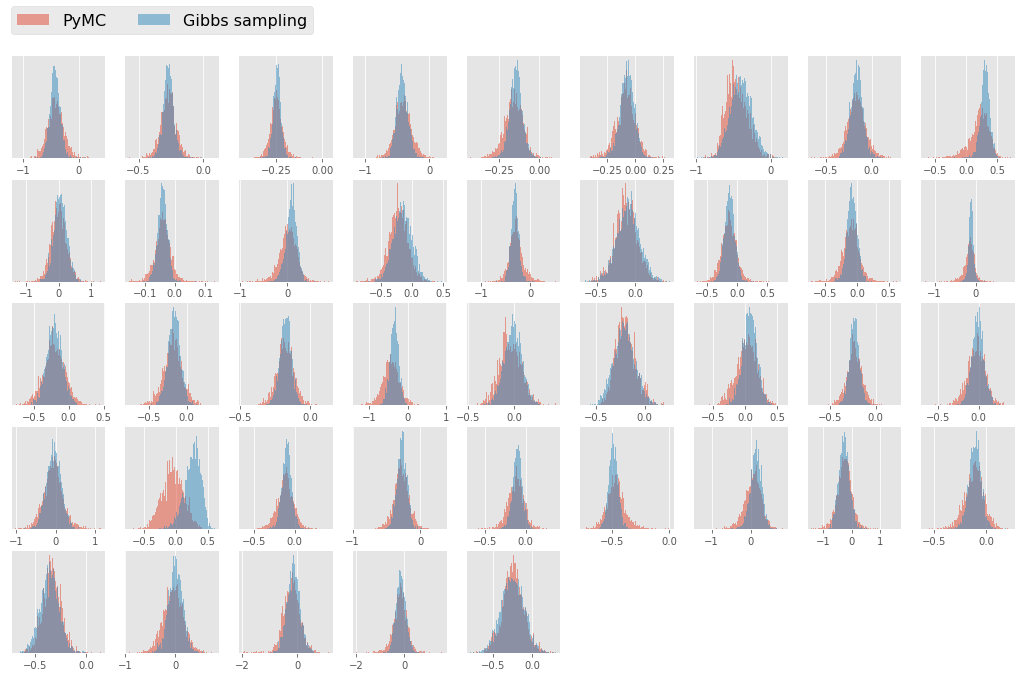

In [80]:
plt.figure(figsize=(18,11), facecolor='white')
for i in range(len(groups)):
    plt.subplot(5,9,i+1)
    plt.hist(hierarchical_trace.get_values('betas')[:,i, 2], density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['betas'][:,2,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    plt.yticks([])
    plt.xticks(fontsize=10)
   # plt.axvline(x=betas_ols[i,1])
    if i == 0:
        plt.legend(loc=(0,1.2), ncol=2)
plt.tight_layout()
plt.savefig('../figures/compare_gibbs_pymc.png', dpi=300, bbox_inches='tight')

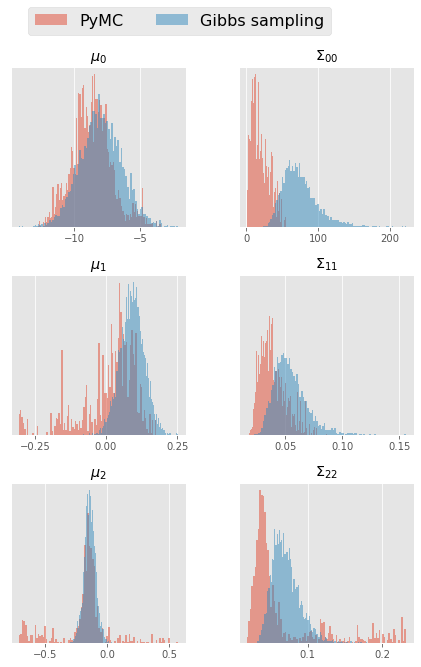

In [81]:
plt.figure(figsize=(7,10), facecolor='white')
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist(hierarchical_trace.get_values(f'mus_beta')[:, i], density=True,  bins=100, alpha=.5)
    plt.hist(gb.traces['mu'][:,i], density=True,  bins=100, alpha=.5)
    plt.xticks(fontsize=10)
    plt.yticks([])
    string = str(i) + str(i)
    plt.title(fr'$\mu_{i}$')
    plt.subplot(3,2,2*i+2)
    plt.hist(hierarchical_trace.get_values(f'sigmas_squared_betas')[:, i], density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['sigmas_diag'][:,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    if i ==0:
        plt.legend(loc=(-1.2,1.2), ncol=2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    tot_string = ('$\Sigma_' + '{' + string + '}$')
    plt.title(tot_string)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('../writeup/compare_gibbs_pymc1.png', dpi=300, bbox_inches='tight')
    

Text(0.5, 1.0, 'sigmas')

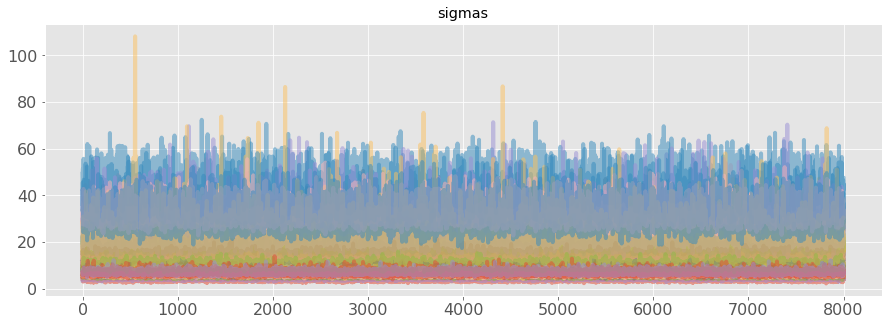

In [29]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(hierarchical_trace.get_values(eps), alpha=.5);
plt.title('sigmas')

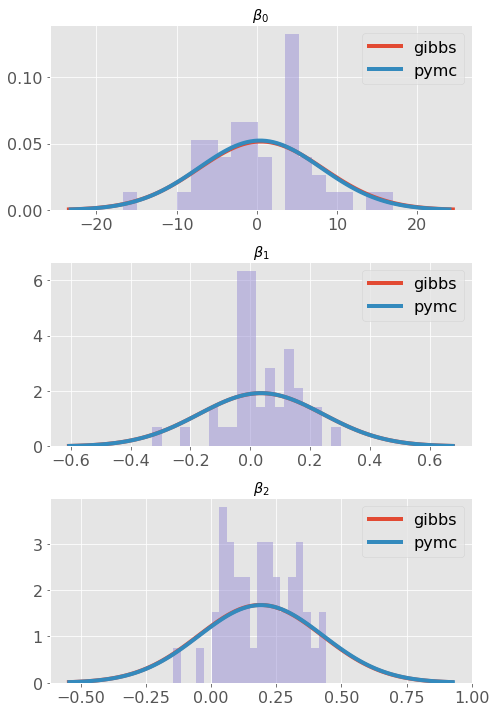

In [9]:
plt.figure(figsize=(7,10), facecolor='white')
means_g = gb.traces['mu'].mean(axis=0)
diag_cov_g = gb.traces['sigmas_diag'].mean(axis=0)
means_p = [hierarchical_trace.get_values(f'mu_beta_{i}').mean() for i in range(3)]
diag_cov_p = [hierarchical_trace.get_values(f'sigma_squared_beta_{i}').mean() for i in range(3)]

from scipy.stats import norm
for i in range(3):
    plt.subplot(3,1,i+1)
    dist = norm(loc=means_g[i], scale=np.sqrt(diag_cov_g[i]))
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='gibbs')
    
    dist = norm(loc=means_p[i], scale=np.sqrt(diag_cov_p[i]))
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='pymc')
    plt.hist(gb.traces['betas'][:,i,:].mean(axis=0), density=True, alpha=.5, bins=20)
    tot_string = (fr'$\beta_' + '{' + str(i) + '}$')
    plt.title(tot_string)
    plt.legend()
plt.tight_layout()

In [14]:
with hierarchical_model:
    predictive_checks = pm.sample_posterior_predictive(hierarchical_trace, return_inferencedata=False, samples=100)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/2896766423.py:2: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  predictive_checks = pm.sample_posterior_predictive(hierarchical_trace, return_inferencedata=False, samples=100)


In [19]:
col_names = ['check' + str(num) for num in range(predictive_checks['data_like'].shape[0])]
df[col_names] = predictive_checks['data_like'].T;

In [31]:
def plot_checks(df, all_axes, col_names):
    ax_number = list(grouped_dataframe.groups.keys()).index(df.name)
    ax = all_axes.flatten()[ax_number]
    data = df[col_names].to_numpy()
    ax.plot(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='black', zorder=3)
    ax.scatter(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='red', s=100, zorder=3)
    ax.plot(df['day_of_the_year'], df[col_names], color='dodgerblue', alpha=.2)
    ax.set_title(df.name)
    ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
    ax.set_xlabel('day of 2020')
    ax.set_ylabel('% change incidents')
    plt.close()

fig, axes = plt.subplots(len(groups), 1, figsize=(20, len(groups) * 4), facecolor='white') 
grouped_dataframe = df.groupby('department_name')
grouped_dataframe.apply(lambda x: plot_checks(x, all_axes=axes, col_names=col_names))
fig.tight_layout()
fig.savefig('../figures/pred_checks_basic_pymc.png', dpi=300, bbox_inches='tight')

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x169de7df0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x16d347b50> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1689b22c0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The ha

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x17009ddb0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1701990c0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1702902e0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58888/722851201.py:9: UserWarning: The ha